In [1]:
import json, sys, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks
from PIL import Image, ImageDraw 
from matplotlib import pyplot as plt
#%matplotlib qt5
from keras import backend as K
import imp
import os

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        imp.reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

# Import Data
f = open(r'../Code/data/shipsnet.json')
dataset = json.load(f)
f.close()
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')
# RGB Seperation
n_spectrum = 3 # color channel (RGB)
width = 80
height = 80
X = input_data.reshape([-1, n_spectrum, width, height])
X.shape
# Converts a class vector to binary class matrix
y = np_utils.to_categorical(output_data, 2) # 2 = # of classes
# Create and shuffle indices
indices = np.arange(0,3600)
np.random.shuffle(indices)
# Create training data
X_train = X[indices].transpose([0,2,3,1]) # change RGB to GBR?
X_train = X_train / 255 # Normalization
y_train = y[indices]
# CNN Design
np.random.seed(42) 

# Linear stack of layers
model = Sequential() 

# Conv2D(# of output filters in the convolution, 
#        height and width of the 2D convolution window,
#        output same length as input (no padding),
#        Specify size when use as the 1st layer,
#        activation function: Rectified Linear Unit)
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
# Reduce the spatial size of the representation, what is max?
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
# Prevent overfitting
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(256, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))
# optimization setup
sgd = SGD(lr=0.005, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=25,
    validation_split=0.317,
    shuffle=True,
    verbose=2)
image = Image.open('../Code/Data/sfbay_3.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1



C:\program zzl\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 2458 samples, validate on 1142 samples
Epoch 1/25
 - 165s - loss: 0.4394 - acc: 0.8145 - val_loss: 0.2970 - val_acc: 0.8888
Epoch 2/25
 - 161s - loss: 0.2685 - acc: 0.8950 - val_loss: 0.2783 - val_acc: 0.9133
Epoch 3/25
 - 158s - loss: 0.2107 - acc: 0.9105 - val_loss: 0.2047 - val_acc: 0.9124
Epoch 4/25
 - 160s - loss: 0.1834 - acc: 0.9227 - val_loss: 0.1816 - val_acc: 0.9299
Epoch 5/25
 - 159s - loss: 0.1677 - acc: 0.9300 - val_loss: 0.1628 - val_acc: 0.9466
Epoch 6/25
 - 159s - loss: 0.1437 - acc: 0.9394 - val_loss: 0.1305 - val_acc: 0.9518
Epoch 7/25
 - 161s - loss: 0.1294 - acc: 0.9483 - val_loss: 0.1346 - val_acc: 0.9641
Epoch 8/25
 - 159s - loss: 0.1176 - acc: 0.9540 - val_loss: 0.1186 - val_acc: 0.9632
Epoch 9/25
 - 161s - loss: 0.0965 - acc: 0.9654 - val_loss: 0.1040 - val_acc: 0.9676
Epoch 10/25
 - 159s - loss: 0.0898 - acc: 0.9662 - val_loss: 0.0786 - val_acc: 0.9781
Epoch 11/25
 - 158s - loss: 0.0900 - acc: 0.9630 - val_loss: 0.0803 - val_acc: 0.9790
Epoch 12/25
 - 

In [2]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])

X:2620 Y:1490  

In [3]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1577, 2709, 3)

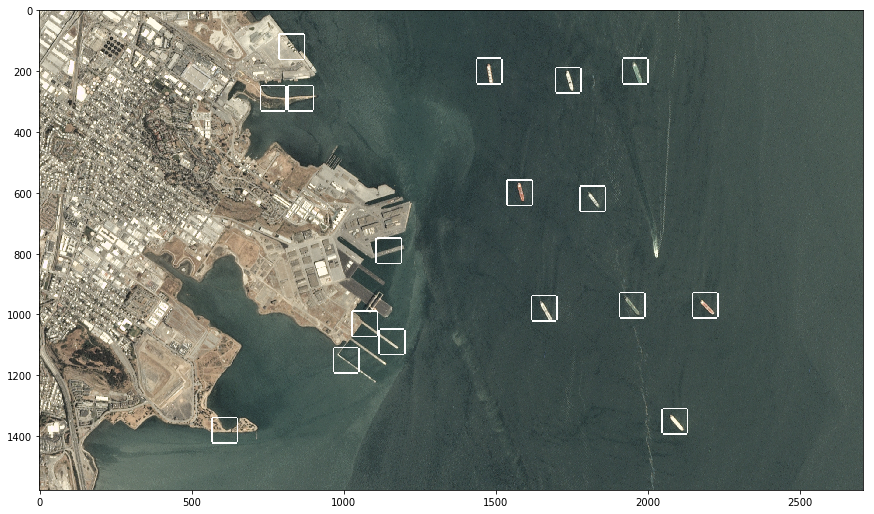

In [4]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

X:1920 Y:1660  

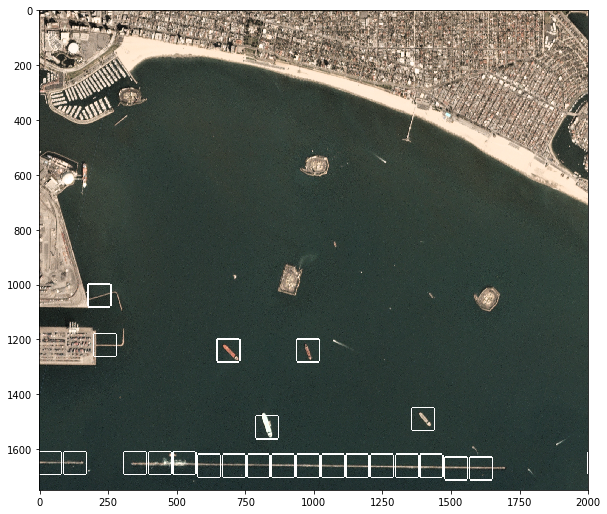

In [5]:
image = Image.open('../Code/Data/lb_1.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

X:2760 Y:1740  

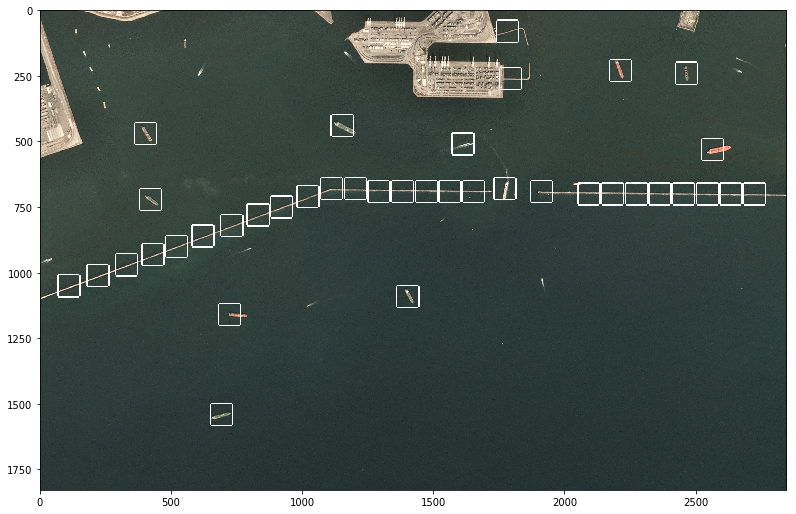

In [6]:
image = Image.open('../Code/Data/lb_2.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

X:2310 Y:1350  

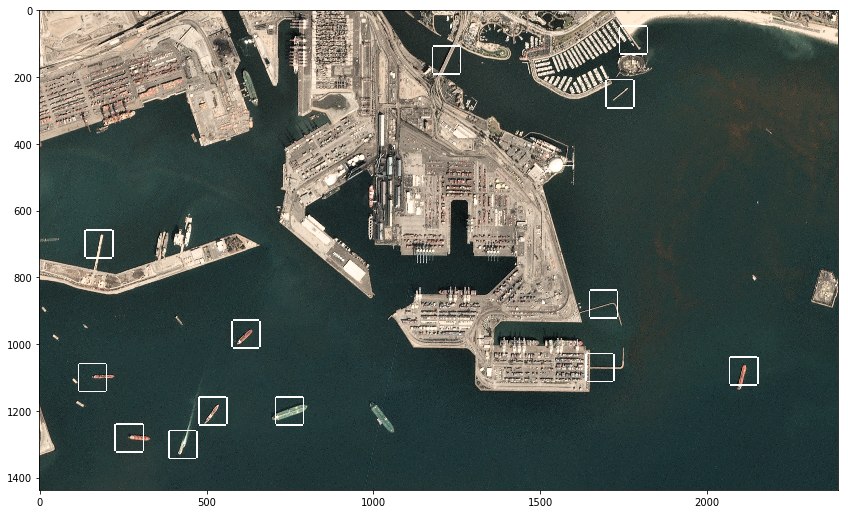

In [7]:
image = Image.open('..//Data/lb_3.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

X:2540 Y:1390  

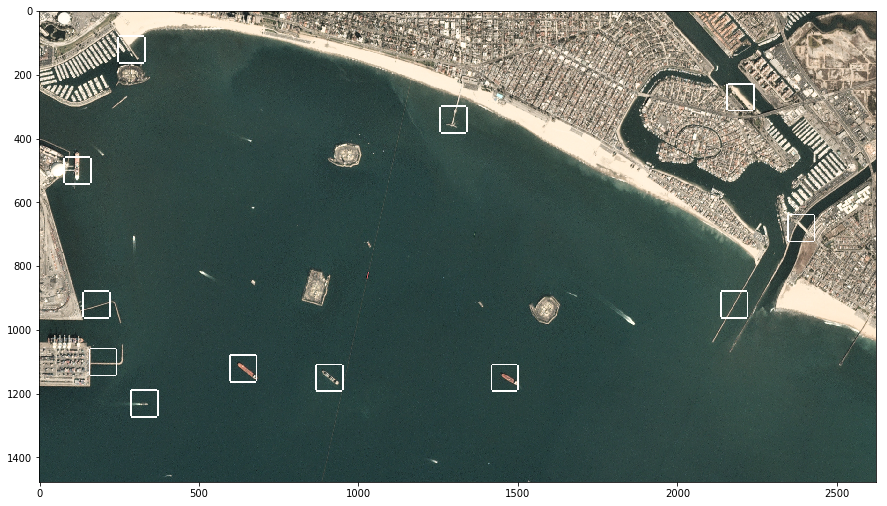

In [8]:
image = Image.open('../207/lb_4.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

X:2740 Y:1690  

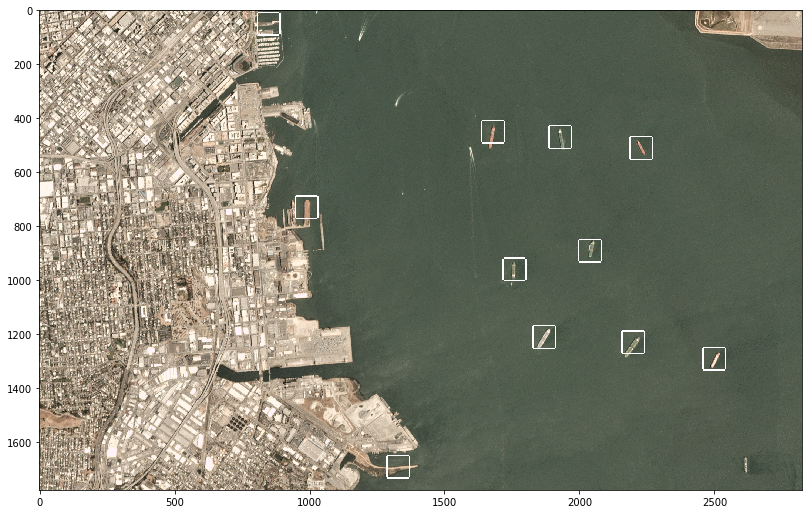

In [9]:
image = Image.open('../207/sfbay_1.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

X:3000 Y:1510  

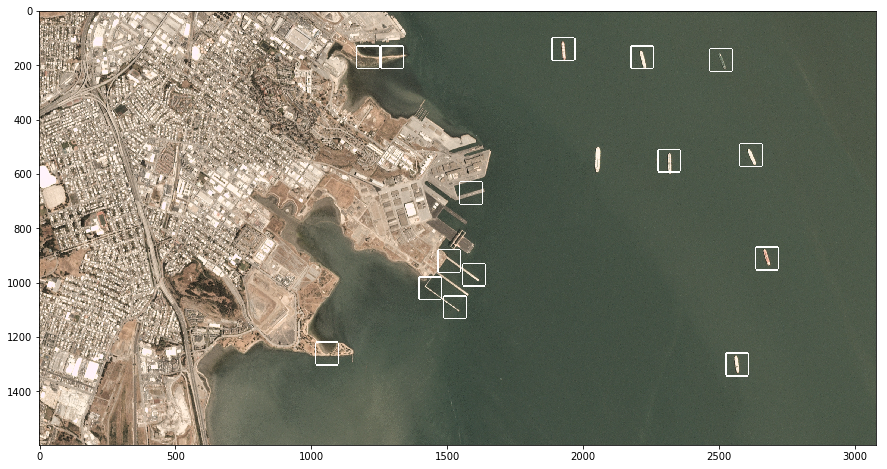

In [10]:
image = Image.open('../207/sfbay_2.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

X:2130 Y:920  

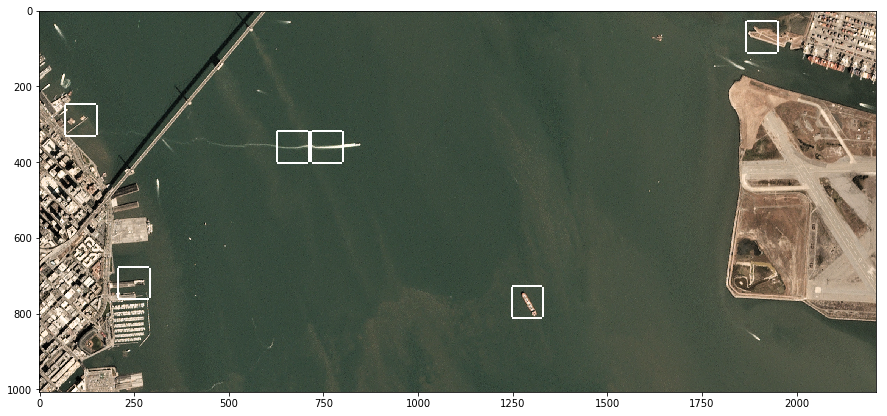

In [11]:
image = Image.open('../207/sfbay_4.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor = picture_tensor.transpose(2,0,1)
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.9 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()